In [1]:
import torch
from torchmetrics import AUROC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os

In [2]:
current_file_dir = os.getcwd()


In [3]:
train_results_json="../out_evaluate_patch/train_scores.json"
val_results_json="../out_evaluate_patch/val_scores.json"
train_results_json=os.path.join(current_file_dir,train_results_json)    
val_results_json=os.path.join(current_file_dir,val_results_json)    




def create_tables(train_data,clases):
    labels=[]
    preds=[]
    for d in train_data:
        truth=[]
        pred=[]
        gt=d['ground_truth']
        scores=d['scores']
        for defecto in clases:
            truth.append(gt[defecto])
            pred.append(scores[defecto])
        labels.append(truth)
        preds.append(pred)
            
    labels=torch.tensor(labels)
    preds=torch.tensor(preds)

    return preds,labels


with open(train_results_json, "r") as f:
    train_dict = json.load(f)

with open(val_results_json, "r") as f:
    val_dict = json.load(f)    

train_data=train_dict['train_results']
val_data = val_dict['val_results']
clases=list(train_dict['train_results'][0]['ground_truth'].keys())

print(len(train_data))
print(len(val_data))

1085
288


In [4]:
preds_train,labels_train=create_tables(train_data,clases)
preds_val,labels_val=create_tables(val_data,clases)

# Cantidad de muestras de con cada defecto

In [5]:
print("==========================================")
print("  ** VAL **")
print("==========================================")

n_por_defecto=labels_val.sum(dim=0)
for k in range(len(clases)):
    print(f'{clases[k]} : {int(n_por_defecto[k].item())}')

k=labels_val.sum(dim=1)

nbuenos=torch.sum(k==0)
print("N sin defectos:",nbuenos.item())
print("N total:",labels_val.shape[0])

print("\n==========================================")
print("  ** TRAIN **")
print("==========================================")

n_por_defecto=labels_train.sum(dim=0)
for k in range(len(clases)):
    print(f'{clases[k]} : {int(n_por_defecto[k].item())}')

k=labels_train.sum(dim=1)

nbuenos=torch.sum(k==0)
print("N sin defectos:",nbuenos.item())
print("N total:",labels_train.shape[0])

  ** VAL **
green : 27
hollow : 21
insect : 8
light_scars : 28
oil_spots : 21
plu_stickers : 15
rotten : 31
scars : 35
skin_breakdown : 19
surface : 73
N sin defectos: 89
N total: 288

  ** TRAIN **
green : 80
hollow : 46
insect : 38
light_scars : 96
oil_spots : 82
plu_stickers : 53
rotten : 134
scars : 132
skin_breakdown : 93
surface : 291
N sin defectos: 334
N total: 1085


# Análisis AUROC por categorías

In [6]:
f_auroc=AUROC(task='multilabel',num_labels=len(clases),average='none')
res=f_auroc(preds_val,labels_val.int())
res=res.tolist()

aucs={}
for c,auc in zip(clases,res):
    aucs[c]=auc
    print(f'AUC-val({c}) : {auc:.3f}')


AUC-val(green) : 0.972
AUC-val(hollow) : 0.858
AUC-val(insect) : 0.825
AUC-val(light_scars) : 0.927
AUC-val(oil_spots) : 0.870
AUC-val(plu_stickers) : 1.000
AUC-val(rotten) : 0.893
AUC-val(scars) : 0.865
AUC-val(skin_breakdown) : 0.894
AUC-val(surface) : 0.959


# Histogramas de probabilidades por clase

## Validación

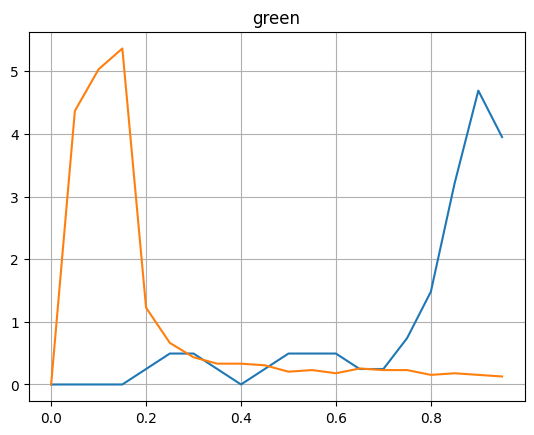

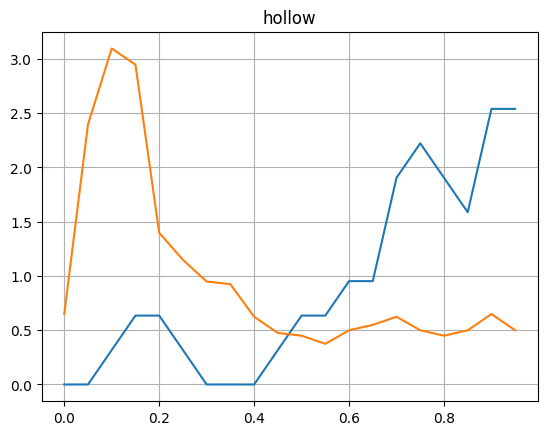

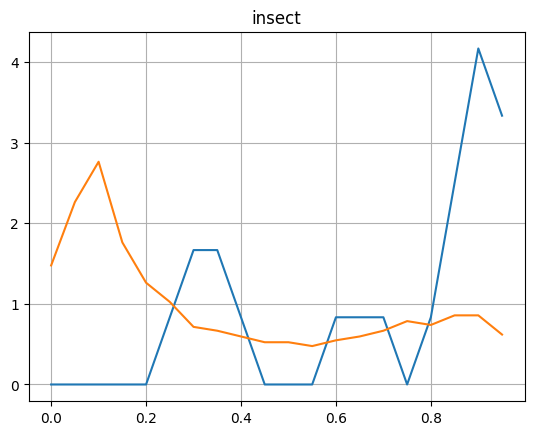

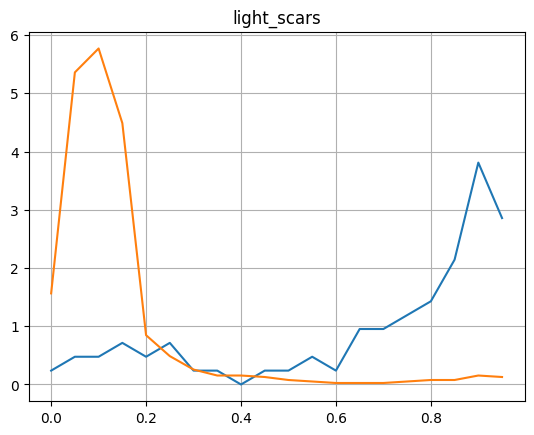

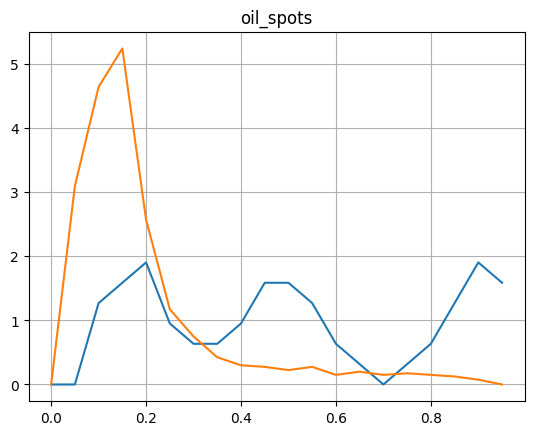

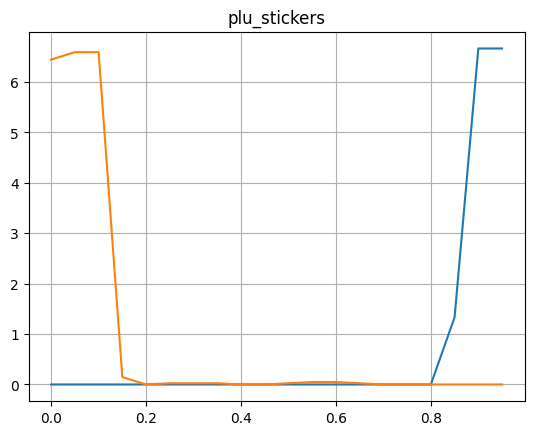

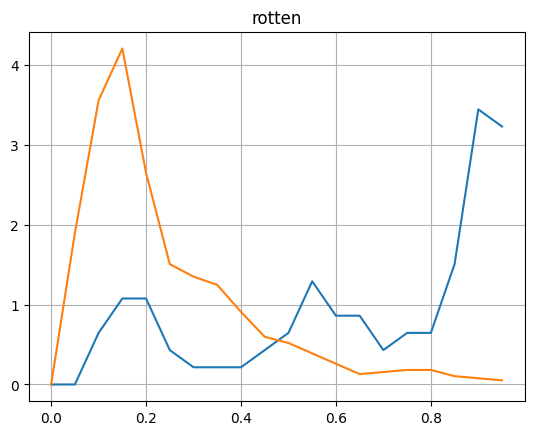

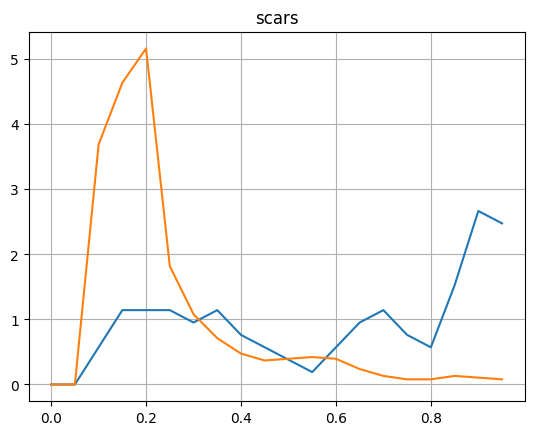

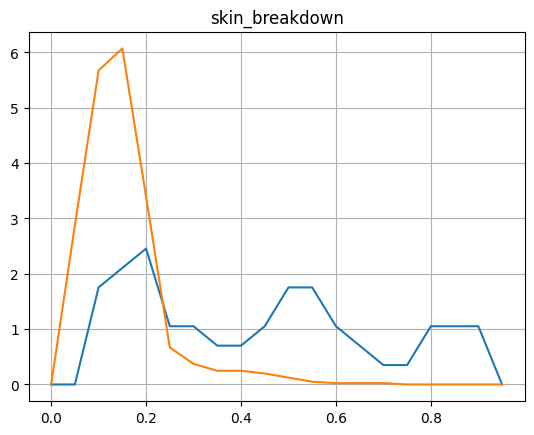

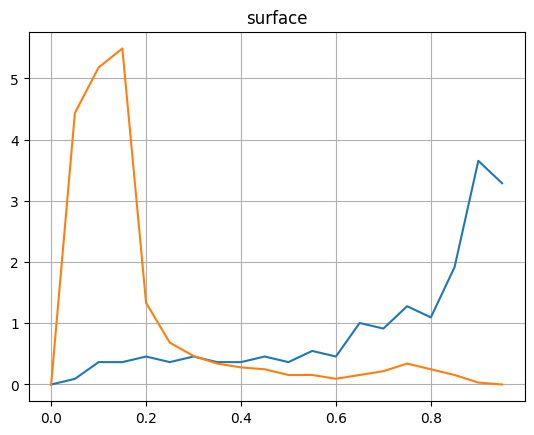

In [7]:
for id_clase in range(len(clases)):
    prob=preds_val[:,id_clase]
    t=labels_val[:,id_clase]

    target_pos=t[t>0.5]
    pred_pos=prob[t>0.5]

    target_neg=t[t<0.5]
    pred_neg=prob[t<0.5]

    
    hh=np.ones(3)/3
    hpos,e=np.histogram(pred_pos,bins=20,range=(0.0,1.0),density=True)
    hneg,f=np.histogram(pred_neg,bins=20,range=(0.0,1.0),density=True)
    
    hpos=np.convolve(hpos, hh, 'same')
    hneg=np.convolve(hneg, hh, 'same')
    _=plt.figure()
    _=plt.plot(e[:-1],hpos)
    _=plt.plot(f[:-1],hneg)
    _=plt.title(clases[id_clase])
    _=plt.grid()